((<PIL.Image.Image image mode=RGB size=512x512>,
  <PIL.Image.Image image mode=RGB size=512x512>,
  <PIL.Image.Image image mode=RGB size=512x512>),
 <Figure size 1500x1200 with 30 Axes>)

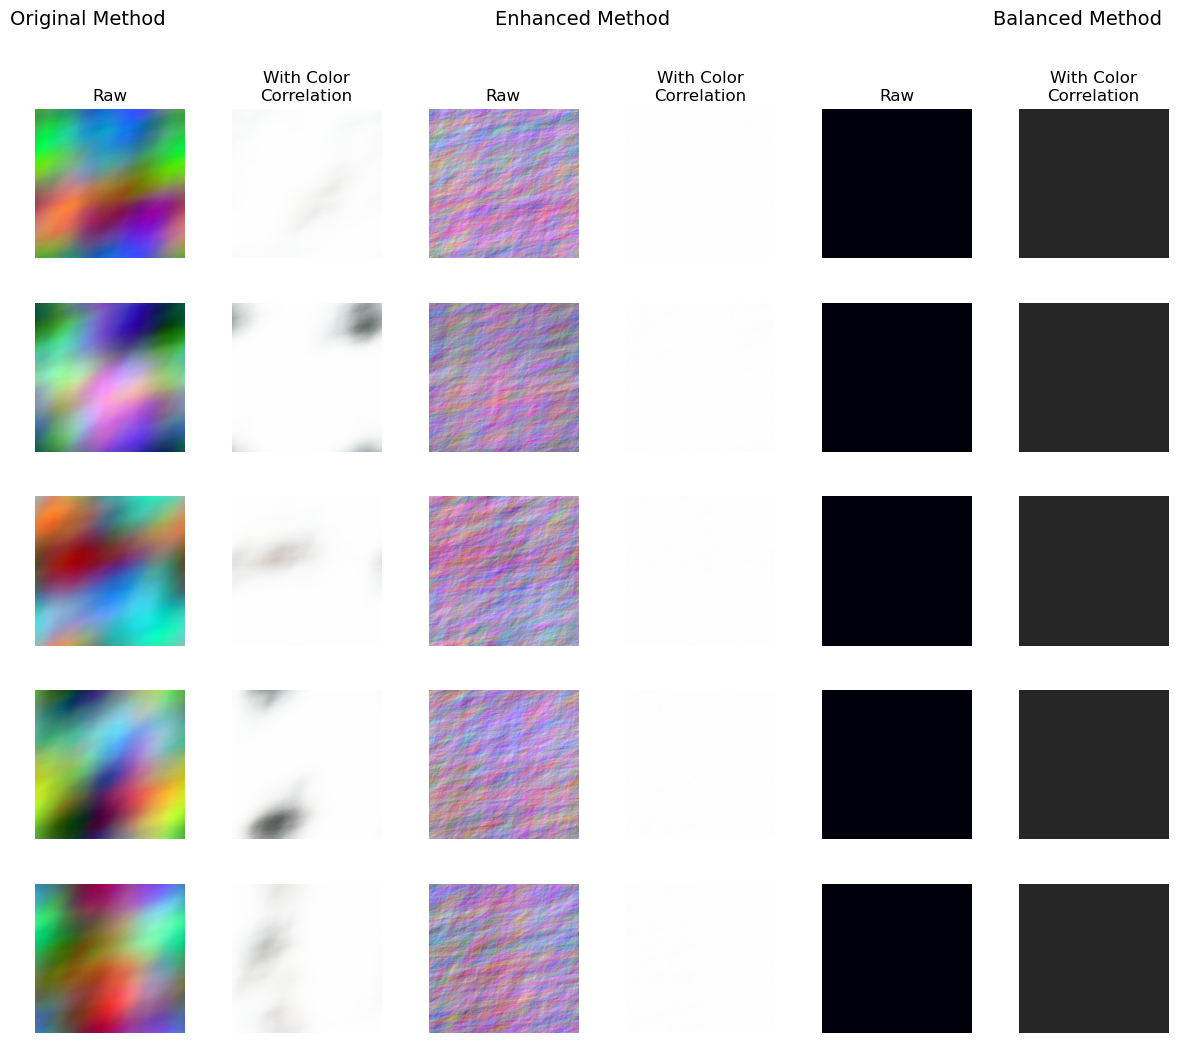

In [ ]:
def visualize_initial_spectrum(size=128, batch_size=1, decay_power=1.5, save_path=None):
    """
    Create and visualize the initial FFT spectrum to understand color initialization.
    
    Args:
        size: Size of the image
        batch_size: Batch size
        decay_power: Decay power for spectrum weights
        save_path: Path to save visualizations (optional)
    
    Returns:
        A tuple of (initial_image, spectrum_visualization)
    """
    import matplotlib.pyplot as plt
    import torch
    import numpy as np
    from torchvision.transforms.functional import to_pil_image
    import os
    
    # Use same device as model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Create a mock EssenceGenerator instance just for the necessary methods
    class MockGenerator:
        def __init__(self, device):
            self.device = device
            self.color_correlation_matrix = torch.tensor([
                [1.0000, 0.9522, 0.9156],
                [0.9522, 1.0000, 0.9708],
                [0.9156, 0.9708, 1.0000]], device=device)
            self.color_boost = 1.5
            
        def create_fft_spectrum_initializer(self, size, batch_size=1):
            """Standard frequency domain initialization"""
            fft_size = size // 2 + 1
            
            # Initialize with zeros
            spectrum_scale = torch.zeros(batch_size, 3, size, fft_size, 2, device=self.device)
            
            # Use 1/f spectrum characteristic of natural images (pink noise)
            for h in range(size):
                for w in range(fft_size):
                    # Calculate distance from DC component
                    dist = np.sqrt((h/size)**2 + (w/fft_size)**2) + 1e-5
                    # Pink noise falls off as 1/f
                    weight = 1.0 / dist
                    # Add random phase but weighted amplitude
                    spectrum_scale[:, :, h, w, 0] = torch.randn(batch_size, 3, device=self.device) * weight * 0.15
                    spectrum_scale[:, :, h, w, 1] = torch.randn(batch_size, 3, device=self.device) * weight * 0.15
            
            # Initialize DC component (average color)
            spectrum_scale[:, 0, 0, 0, 0] = 0.5  # Red channel
            spectrum_scale[:, 1, 0, 0, 0] = 0.4  # Green channel
            spectrum_scale[:, 2, 0, 0, 0] = 0.6  # Blue channel
            spectrum_scale[:, :, 0, 0, 1] = 0
            
            # Phase component
            spectrum_shift = torch.randn(batch_size, 3, size, fft_size, 2, device=self.device) * 0.05
            
            return spectrum_scale, spectrum_shift
        
        def create_enhanced_fft_spectrum_initializer(self, size, batch_size=1):
            """Enhanced frequency domain initialization with better colors"""
            fft_size = size // 2 + 1
            
            # Initialize with zeros
            spectrum_scale = torch.zeros(batch_size, 3, size, fft_size, 2, device=self.device)
            
            # Use 1/f spectrum characteristic of natural images (pink noise)
            for h in range(size):
                for w in range(fft_size):
                    # Calculate distance from DC component
                    dist = np.sqrt((h/size)**2 + (w/fft_size)**2) + 1e-5
                    # Pink noise falls off as 1/f
                    weight = 1.0 / dist
                    # Add random phase but weighted amplitude - increased amplitude
                    spectrum_scale[:, :, h, w, 0] = torch.randn(batch_size, 3, device=self.device) * weight * 0.25
                    spectrum_scale[:, :, h, w, 1] = torch.randn(batch_size, 3, device=self.device) * weight * 0.25
            
            # Initialize DC component with higher values for stronger colors
            spectrum_scale[:, 0, 0, 0, 0] = 0.7  # Red channel - increased
            spectrum_scale[:, 1, 0, 0, 0] = 0.5  # Green channel - increased
            spectrum_scale[:, 2, 0, 0, 0] = 0.8  # Blue channel - increased
            spectrum_scale[:, :, 0, 0, 1] = 0
            
            # Add color variations to low frequencies for more vibrant patterns
            for c in range(3):
                # Add some color to very low frequencies (first few harmonics)
                for h in range(1, 4):
                    for w in range(1, 4):
                        # Random but weighted color components for variety
                        spectrum_scale[:, c, h, w, 0] = torch.randn(batch_size, device=self.device) * 0.2 * (3-c)/3
                        spectrum_scale[:, c, h, w, 1] = torch.randn(batch_size, device=self.device) * 0.2 * (3-c)/3
            
            # Phase component - increased for more variation
            spectrum_shift = torch.randn(batch_size, 3, size, fft_size, 2, device=self.device) * 0.1
            
            return spectrum_scale, spectrum_shift
        
        def create_balanced_fft_spectrum_initializer(self, size, batch_size=1):
            """Balanced frequency domain initialization"""
            fft_size = size // 2 + 1
            
            # Initialize with zeros
            spectrum_scale = torch.zeros(batch_size, 3, size, fft_size, 2, device=self.device)
            
            # Use 1/f spectrum characteristic of natural images (pink noise)
            for h in range(size):
                for w in range(fft_size):
                    # Calculate distance from DC component
                    dist = np.sqrt((h/size)**2 + (w/fft_size)**2) + 1e-5
                    # Pink noise falls off as 1/f
                    weight = 1.0 / dist
                    # Add random phase but weighted amplitude - moderate amplitude
                    spectrum_scale[:, :, h, w, 0] = torch.randn(batch_size, 3, device=self.device) * weight * 0.18
                    spectrum_scale[:, :, h, w, 1] = torch.randn(batch_size, 3, device=self.device) * weight * 0.18
            
            # Initialize DC component with moderate values
            spectrum_scale[:, 0, 0, 0, 0] = 0.55  # Red channel
            spectrum_scale[:, 1, 0, 0, 0] = 0.45  # Green channel
            spectrum_scale[:, 2, 0, 0, 0] = 0.65  # Blue channel
            spectrum_scale[:, :, 0, 0, 1] = 0
            
            # Add subtle color distinctions to low frequencies
            for c in range(3):
                for h in range(1, 3):
                    for w in range(1, 3):
                        # Give each channel slightly different weights
                        channel_weight = 0.08 * (1 + 0.2 * (c - 1))
                        spectrum_scale[:, c, h, w, 0] = torch.randn(batch_size, device=self.device) * channel_weight
                        spectrum_scale[:, c, h, w, 1] = torch.randn(batch_size, device=self.device) * channel_weight
            
            # Phase component
            spectrum_shift = torch.randn(batch_size, 3, size, fft_size, 2, device=self.device) * 0.06
            
            return spectrum_scale, spectrum_shift
        
        def create_spectrum_weights(self, size, decay_power=1.0):
            """Create weights for the spectrum."""
            freqs_x = torch.fft.rfftfreq(size).view(1, -1).to(self.device)
            freqs_y = torch.fft.fftfreq(size).view(-1, 1).to(self.device)
            
            dist_from_center = torch.sqrt(freqs_x**2 + freqs_y**2)
            
            # Weight calculation
            weights = 1.0 / (dist_from_center + 1e-8) ** decay_power
            
            # Add mid-frequency boost
            mid_freq_mask = (dist_from_center > 0.05) & (dist_from_center < 0.3)
            weights = weights * (1.0 + 1.0 * mid_freq_mask.float())
            
            # Add high-frequency boost
            high_freq_mask = (dist_from_center >= 0.3) & (dist_from_center < 0.7)
            weights = weights * (1.0 + 0.3 * high_freq_mask.float())
            
            weights = weights / weights.max()
            weights[0, 0] = 0.8  # DC component
            
            return weights
        
        def fft_to_rgb_original(self, spectrum_scale, spectrum_shift, size, spectrum_weight=None):
            """Original FFT to RGB conversion (per-channel normalization)"""
            batch_size = spectrum_scale.shape[0]
            
            if spectrum_weight is not None:
                spectrum_scale = spectrum_scale * spectrum_weight.unsqueeze(0).unsqueeze(0).unsqueeze(-1)
            
            image = torch.zeros(batch_size, 3, size, size, device=self.device)
            
            spectrum_complex = torch.complex(
                spectrum_scale[..., 0], 
                spectrum_scale[..., 1]
            )
            
            phase_shift = torch.complex(
                torch.cos(spectrum_shift[..., 0]), 
                torch.sin(spectrum_shift[..., 1])
            )
            spectrum_complex = spectrum_complex * phase_shift
            
            for b in range(batch_size):
                for c in range(3):
                    channel_spectrum = spectrum_complex[b, c]
                    channel_image = torch.fft.irfft2(channel_spectrum, s=(size, size))
                    
                    channel_min = channel_image.min()
                    channel_max = channel_image.max()
                    if channel_max > channel_min:
                        channel_image = (channel_image - channel_min) / (channel_max - channel_min)
                    else:
                        channel_image = torch.zeros_like(channel_image)
                    
                    image[b, c] = channel_image
            
            return image
        
        def fft_to_rgb_enhanced(self, spectrum_scale, spectrum_shift, size, spectrum_weight=None):
            """Enhanced FFT to RGB conversion with global normalization"""
            batch_size = spectrum_scale.shape[0]
            
            if spectrum_weight is not None:
                spectrum_scale = spectrum_scale * (0.7 + 0.3 * spectrum_weight.unsqueeze(0).unsqueeze(0).unsqueeze(-1))
            
            image = torch.zeros(batch_size, 3, size, size, device=self.device)
            
            spectrum_complex = torch.complex(
                spectrum_scale[..., 0], 
                spectrum_scale[..., 1]
            )
            
            phase_shift = torch.complex(
                torch.cos(spectrum_shift[..., 0]), 
                torch.sin(spectrum_shift[..., 1])
            )
            spectrum_complex = spectrum_complex * phase_shift
            
            # First pass to find global min/max for normalization
            channel_min_global = float('inf')
            channel_max_global = float('-inf')
            
            for b in range(batch_size):
                for c in range(3):
                    channel_spectrum = spectrum_complex[b, c]
                    channel_image = torch.fft.irfft2(channel_spectrum, s=(size, size))
                    
                    channel_min = channel_image.min().item()
                    channel_max = channel_image.max().item()
                    
                    if channel_min < channel_min_global:
                        channel_min_global = channel_min
                    if channel_max > channel_max_global:
                        channel_max_global = channel_max
            
            # Second pass to normalize with global values
            for b in range(batch_size):
                for c in range(3):
                    channel_spectrum = spectrum_complex[b, c]
                    channel_image = torch.fft.irfft2(channel_spectrum, s=(size, size))
                    
                    # Normalize with global values to preserve color relationships
                    if channel_max_global > channel_min_global:
                        channel_image = (channel_image - channel_min_global) / (channel_max_global - channel_min_global)
                    else:
                        channel_image = torch.zeros_like(channel_image)
                    
                    # Apply color boosting
                    color_boost_factors = [1.2, 1.0, 1.3]  # Boost R and B slightly more than G
                    channel_image = torch.pow(channel_image, 0.8) * color_boost_factors[c]
                    
                    image[b, c] = torch.clamp(channel_image, 0, 1)
            
            return image
        
        def fft_to_rgb_balanced(self, spectrum_scale, spectrum_shift, size, spectrum_weight=None):
            """Balanced FFT to RGB conversion with blended normalization"""
            batch_size = spectrum_scale.shape[0]
            
            if spectrum_weight is not None:
                spectrum_scale = spectrum_scale * spectrum_weight.unsqueeze(0).unsqueeze(0).unsqueeze(-1)
            
            image = torch.zeros(batch_size, 3, size, size, device=self.device)
            
            spectrum_complex = torch.complex(
                spectrum_scale[..., 0], 
                spectrum_scale[..., 1]
            )
            
            phase_shift = torch.complex(
                torch.cos(spectrum_shift[..., 0]), 
                torch.sin(spectrum_shift[..., 1])
            )
            spectrum_complex = spectrum_complex * phase_shift
            
            # Find per-channel min/max values
            channel_min_values = []
            channel_max_values = []
            
            for b in range(batch_size):
                for c in range(3):
                    channel_spectrum = spectrum_complex[b, c]
                    channel_image = torch.fft.irfft2(channel_spectrum, s=(size, size))
                    
                    channel_min = channel_image.min().item()
                    channel_max = channel_image.max().item()
                    
                    channel_min_values.append(channel_min)
                    channel_max_values.append(channel_max)
            
            # Calculate global min/max
            global_min = min(channel_min_values)
            global_max = max(channel_max_values)
            global_range = global_max - global_min
            
            # Normalize with blended approach
            for b in range(batch_size):
                for c in range(3):
                    channel_spectrum = spectrum_complex[b, c]
                    channel_image = torch.fft.irfft2(channel_spectrum, s=(size, size))
                    
                    channel_min = channel_min_values[b*3 + c]
                    channel_max = channel_max_values[b*3 + c]
                    channel_range = channel_max - channel_min
                    
                    if channel_range > 1e-8 and global_range > 1e-8:
                        # Apply a partially shared normalization (70% global, 30% per-channel)
                        blend_factor = 0.7
                        
                        global_norm = (channel_image - global_min) / global_range
                        channel_norm = (channel_image - channel_min) / channel_range
                        
                        channel_image = blend_factor * global_norm + (1 - blend_factor) * channel_norm
                    else:
                        channel_image = torch.zeros_like(channel_image)
                    
                    # Apply subtle color bias
                    color_bias = 0.05 * (c - 1)  # -0.05, 0, 0.05 for RGB
                    channel_image = torch.clamp(channel_image + color_bias, 0, 1)
                    
                    image[b, c] = channel_image
            
            return image
        
        def apply_color_correlation(self, image):
            """Apply color correlation for more vibrant colors"""
            batch_size, _, height, width = image.shape
            
            # Apply color correlation
            flat_image = image.view(batch_size, 3, -1)
            correlated = torch.matmul(self.color_correlation_matrix, flat_image)
            correlated_image = correlated.view(batch_size, 3, height, width)
            
            # Calculate luminance
            luminance = 0.3 * image[:, 0:1] + 0.59 * image[:, 1:2] + 0.11 * image[:, 2:3]
            
            # Boost colors away from luminance
            boosted_image = luminance + (correlated_image - luminance) * self.color_boost
            
            # Apply S-curve for better contrast
            boosted_image = 0.5 + torch.tanh((boosted_image - 0.5) * 2) * 0.5
            
            # Ensure values are in [0, 1] range
            boosted_image = torch.clamp(boosted_image, 0, 1)
            
            return boosted_image
    
    # Create mock generator
    generator = MockGenerator(device)
    
    # Create spectrum weights
    weights = generator.create_spectrum_weights(size, decay_power=decay_power)
    
    # Generate visualizations for all three methods
    results = []
    methods = {
        "Original": {
            "initializer": generator.create_fft_spectrum_initializer,
            "converter": generator.fft_to_rgb_original
        },
        "Enhanced": {
            "initializer": generator.create_enhanced_fft_spectrum_initializer,
            "converter": generator.fft_to_rgb_enhanced
        },
        "Balanced": {
            "initializer": generator.create_balanced_fft_spectrum_initializer,
            "converter": generator.fft_to_rgb_balanced
        }
    }
    
    for method_name, functions in methods.items():
        # Create 5 different initializations to see variety
        for seed in range(5):
            # Set random seed for reproducibility
            torch.manual_seed(seed)
            np.random.seed(seed)
            
            # Generate spectrum parameters
            spectrum_scale, spectrum_shift = functions["initializer"](size, batch_size)
            
            # Convert to RGB image
            raw_image = functions["converter"](spectrum_scale, spectrum_shift, size, weights)
            
            # Apply color correlation
            correlated_image = generator.apply_color_correlation(raw_image)
            
            # Convert to PIL images
            raw_pil = to_pil_image(raw_image[0].cpu())
            correlated_pil = to_pil_image(correlated_image[0].cpu())
            
            results.append({
                "method": method_name,
                "seed": seed,
                "raw": raw_pil,
                "correlated": correlated_pil
            })
    
    # Create visualization figure
    fig, axes = plt.subplots(5, 6, figsize=(15, 12))
    plt.subplots_adjust(hspace=0.3, wspace=0.1)
    
    # Add super titles
    fig.text(0.17, 0.95, "Original Method", fontsize=14, ha='center')
    fig.text(0.5, 0.95, "Enhanced Method", fontsize=14, ha='center')
    fig.text(0.83, 0.95, "Balanced Method", fontsize=14, ha='center')
    
    # Group by seed to show the different methods side by side
    for seed in range(5):
        row = seed
        for method_idx, method_name in enumerate(["Original", "Enhanced", "Balanced"]):
            # Find matching result
            method_results = [r for r in results if r["method"] == method_name and r["seed"] == seed]
            if method_results:
                result = method_results[0]
                
                # Raw image (before color correlation)
                col = method_idx * 2
                axes[row, col].imshow(np.array(result["raw"]))
                if row == 0:
                    axes[row, col].set_title("Raw")
                axes[row, col].axis('off')
                
                # After color correlation
                col = method_idx * 2 + 1
                axes[row, col].imshow(np.array(result["correlated"]))
                if row == 0:
                    axes[row, col].set_title("With Color\nCorrelation")
                axes[row, col].axis('off')
    
    # Add row labels
    for seed in range(5):
        axes[seed, 0].set_ylabel(f"Seed {seed}", rotation=90, va='center', ha='right')
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    # Return representative examples (first initialization of each method)
    original = [r for r in results if r["method"] == "Original" and r["seed"] == 0][0]["correlated"]
    enhanced = [r for r in results if r["method"] == "Enhanced" and r["seed"] == 0][0]["correlated"]
    balanced = [r for r in results if r["method"] == "Balanced" and r["seed"] == 0][0]["correlated"]
    
    return (original, enhanced, balanced), fig

# Call the function to generate visualizations
visualize_initial_spectrum(size=128, batch_size=1, decay_power=1.5)